# Comparing modelled versus observed soil temperature

Started 2023-04-21

modified from LSP notebook. 

This notebooks illustrates relating the CLM-FATES model output to available observational data from the Vestland Climate Grid. We use modelled and observed soil temperatures as an example. The workflow highlights common challenges for comparing ecological observations to LSM/DGVM data. General hurdles are...

- ...harmonizing the temporal and spatial scales (aggregated grid cell resolutions (km) vs. local observations (cm-m), decade to century scale simulations vs. few year observational studies, etc.)
- ...different jargon and scientific foci (e.g. variables of interest, species-level studies vs. PFT representation in models, etc.)
- ...data access, documentation, and formats

There are datasets for various ecological experiments in the `Vestland Climate Grid`, for example vegetation removal. This workflow example highly benefits from the VCG data following the [FAIR principles](https://www.go-fair.org/fair-principles/) for data management and stewardship. We can directly access it from the open data management platform [OSF](https://osf.io/) and attain an easily reproducible analysis.

In this notebook, we will...
1. Load model output data
2. Plot the model observations alone
3. Download observational data from OSF
4. Plot the observational data
5. Plot modelled and observed data together

## Specify folders and load VCG data
start by loading necessary libraries:

In [106]:
import xarray as xr  # NetCDF data handling
import matplotlib.pyplot as plt  # Plotting
import time  # Keeping track of runtime
import json  # For reading data dictionaries stored in json format
import pandas as pd  # Tabular data analysis
import datetime as dt  # For workaround with long simulations (beyond year 2262)
from pathlib import Path  # For easy path handling
import numpy as np

Check the current working directory before modifying paths further down

In [6]:
%%bash
pwd

/mnt/c/Users/evaler/OneDrive - Universitetet i Oslo/Eva/PHD/FATES_INCLINE/src/analysis_and_plotting


Define paths to concatenated output files

In [107]:
# Enter the site code from the LSP
site_code = "ALP4"

# Path to concatenated land archive output
output_data_path = f"../../results/3year_subsets"

# Enter the names of single output files from each simulation, created with the 'combine_model_history_files' notebook.
file_path_DA = f"{output_data_path}/DA.1498-1500.nc"
file_path_DB = f"{output_data_path}/DB.1498-1500.nc"
file_path_IA = f"{output_data_path}/IA.1498-1500.nc"
file_path_IB = f"{output_data_path}/IB.1498-1500.nc"
file_path_IW = f"{output_data_path}/IW.1498-1500.nc"
file_path_IBSP = f"{output_data_path}/IBSP.1498-1500.nc"
file_path_IWSP = f"{output_data_path}/IWSP.1498-1500.nc"

# check that they look correct by printing one
file_path_DA

'../../results/3year_subsets/DA.1498-1500.nc'

Then read in the data

In [109]:
# read in the data with loop:
file_paths = {
    'DA': file_path_DA,
    'DB': file_path_DB,
    'IA': file_path_IA,
    'IB': file_path_IB,
    'IW': file_path_IW,
    'IBSP': file_path_IBSP,
    'IWSP': file_path_IWSP
}

data = {}

for dataset, path in file_paths.items():
    data[dataset] = xr.open_mfdataset(path, 
                                      combine='by_coords', 
                                      decode_times=True)

---
## Modelled soil temperature
We will extract modelled soil temperature from the CLM-FATES simulation output and relate them to the counterpart measurements from the field. CLM-FATES mechanistically calculates soil temperature and heat transfer based on e.g. the atmospheric forcings, soil and land cover characteristics, and other modelled properties such as the snow cover or the radiative transer through the modelled vegetation. Note that the forcing data (GSWP3 or COSMO-REA6) and the observed values cover different time spans. We will not be able to compare the exact same points in time - but it does give us an idea if the model somewhat realistically represents the observed patterns.

The next code cells specify the variable name to look at, converts it from Kelvin to Cescius, and plots the depth levels in the soil column:

In [110]:
# Soil temperature history variable in CLM
CLM_soil_temp = "TSOI"

In [29]:
# Retrieve soil temperature from model output, convert to deg. C

# for Default baseline simulation (GSWP3, grass PFTs)
DB_soil_temp = data['DB'][CLM_soil_temp] - 273.15
DB_soil_temp.attrs["long_name"] = "Soil temperature per ground level"
DB_soil_temp.attrs["units"] = "deg.C"
DB_soil_temp

<xarray.DataArray 'TSOI' (time: 36, levgrnd: 25, lndgrid: 1)>
dask.array<sub, shape=(36, 25, 1), dtype=float32, chunksize=(36, 25, 1), chunktype=numpy.ndarray>
Coordinates:
  * levgrnd  (levgrnd) float32 0.01 0.04 0.09 0.16 ... 13.33 19.48 28.87 42.0
  * time     (time) object 1498-02-01 00:00:00 ... 1501-01-01 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    long_name:  Soil temperature per ground level
    units:      deg.C

Investigate the vertical resolution of the included ground levels. See:
https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Ecosystem/CLM50_Tech_Note_Ecosystem.html#id17

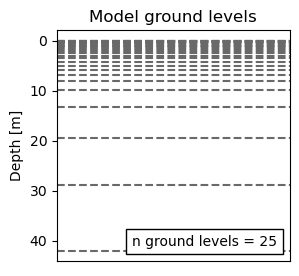

In [71]:
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(3, 3))

for ground_level in DB_soil_temp.levgrnd.values:
    
    ax.axhline(ground_level,
               color="#696969",
               linestyle="dashed",
              )
# Plot layout
ax.set_title("Model ground levels")
ax.set_ylabel("Depth [m]")
ax.get_xaxis().set_visible(False)
ax.invert_yaxis()

# Add text box to show number of ground levels
anchored_text = AnchoredText(f"n ground levels = {len(DB_soil_temp.levgrnd.values)}", loc=4)
ax.add_artist(anchored_text)

Plot the modelled ground temperatures for the top ground levels.

In [67]:
# number of ground levels to plot
max_depth = 5  # in meters
idx_soil_layers_5m = (DB_soil_temp.levgrnd < max_depth).values.sum() - 1
print("Number of ground levels to plot:", idx_soil_layers_5m)

Number of ground levels to plot: 15


In [68]:
# hack around a time format problem
DB_soil_temp['time'] = range(len(DB_soil_temp["time"]))

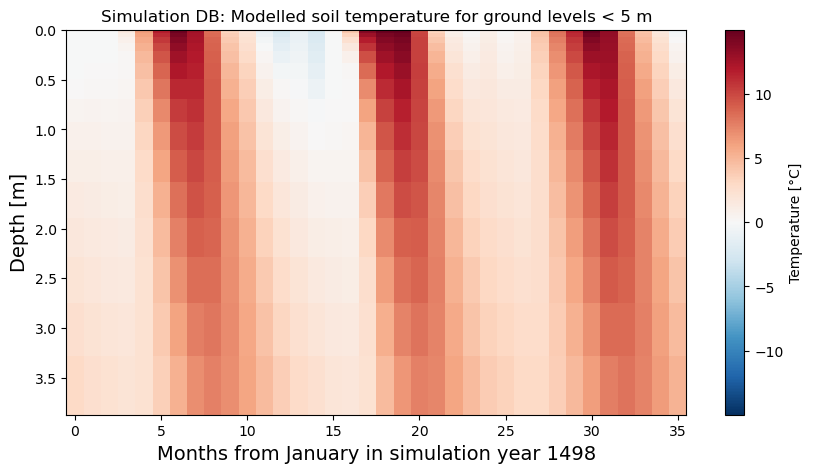

In [73]:
# make the plot
fig, ax = plt.subplots(figsize=(10, 5))
color_bar_plot = copy.isel(levgrnd=slice(0, idx_soil_layers_15m)).T.plot(x='time', y='levgrnd', ax=ax,
cbar_kwargs={
        'label': "Temperature [°C]"
        }
)
# Make plot more intuitive by setting depth=0 to the top
ax.invert_yaxis()
# Title and labels
ax.set_title(f"Simulation DB: Modelled soil temperature for ground levels < 5 m")
ax.set_ylabel("Depth [m]", fontsize=14)
ax.set_xlabel("Months from January in simulation year 1498", fontsize=14);

Make the same plot for the rest of the simulations:

In [111]:
# Fix data
# list simulations
simulations = ['DA', 
               'DB', 
               'IA', 
               'IB', 
               'IBSP',
               'IW', 
               'IWSP'
               ]

# Create an empty dictionary to store the data sets
soil_temp_data = {}

# Loop over simulations
for sim in simulations:
    # Retrieve soil temperature from model output, convert to deg. C
    sim_soil_temp = data[sim][CLM_soil_temp] - 273.15
    sim_soil_temp.attrs["long_name"] = "Soil temperature per ground level"
    sim_soil_temp.attrs["units"] = "deg.C"
    # Hack around a time format problem
    sim_soil_temp['time'] = range(len(sim_soil_temp["time"]))
    
    # Add the data set to the dictionary with the simulation name as the key
    soil_temp_data[sim] = sim_soil_temp


In [112]:

# Loop over simulations
for sim, sim_data in soil_temp_data.items():
    # Make the plots
    fig, ax = plt.subplots(figsize=(10, 5))
    color_bar_plot = sim_data.isel(levgrnd=slice(0, idx_soil_layers_15m)).T.plot(x='time', y='levgrnd', ax=ax,
        cbar_kwargs={
            'label': "Temperature [°C]"
        }
    )
    # Make plot more intuitive by setting depth=0 to the top
    ax.invert_yaxis()
    # Title and labels
    ax.set_title(f"Simulation {sim}: Modelled soil temperature for ground levels < 5 m")
    ax.set_ylabel("Depth [m]", fontsize=12)
    ax.set_xlabel("Months from January in simulation year 1498", fontsize=12)

    # Save figure
    fig.tight_layout()
    fig.savefig(fname=f"../../results/figures/soil_temperature_{sim}.png", format='png')
    plt.close(fig)

## Observed soil temperature

### Download data
Next, we will load the observational data. Refer to https://osf.io/4c5v2/ for the full documentation and additional information. We can directly download the data from OSF into a DataFrame using the Python code below.

**Citation**: Vandvik, V., Telford, R. J., Halbritter, A. H., Jaroszynska, F., Lynn, J. S., Geange, S. R., … Rüthers, J. (2022, April 5). FunCaB - The role of functional group interactions in mediating climate change impacts on the Carbon dynamics and biodiversity of alpine ecosystems. Retrieved from osf.io/4c5v2.

The next code cells will download the data, make some adjustments, and create monthly means that can be compared to the default monthly model output.

In [76]:
# Download data directly from OSF storage, make sure you are connected to the internet
vcg_soil_temp_obs_df = pd.read_csv("https://osf.io/7tgxb/download", low_memory=False)

In [77]:
# Print first rows
vcg_soil_temp_obs_df.head()

,year,date_time,siteID,blockID,plotID,iButtonID,treatment,soiltemperature,comments,turfID
0,2015,2015-07-12T17:58:01Z,Alrust,Alr3,Alr3GF,3BC3A141_2016,GF,15.475,NaN,NaN
1,2015,2015-07-12T20:22:01Z,Alrust,Alr3,Alr3GF,3BC3A141_2016,GF,14.911,NaN,NaN
2,2015,2015-07-12T22:46:01Z,Alrust,Alr3,Alr3GF,3BC3A141_2016,GF,14.347,NaN,NaN
3,2015,2015-07-13T01:10:01Z,Alrust,Alr3,Alr3GF,3BC3A141_2016,GF,13.846,NaN,NaN
4,2015,2015-07-13T03:34:01Z,Alrust,Alr3,Alr3GF,3BC3A141_2016,GF,13.532,NaN,NaN


In [78]:
# Read dictionary for mapping the name of the NorESM platform site codes to the corresponding name in the VCG dataset
with open(Path("./dicts/vestland_climate_grid.json"), 'r', encoding='utf-8') as vcg_site_json:
    vcg_site_dict = json.load(vcg_site_json).get("sites")

In [79]:
# Subset soil temperatures for my site (ALP4 = Skjellingahaugen)
mysite_soil_temp_obs_df = vcg_soil_temp_obs_df[vcg_soil_temp_obs_df["siteID"] == vcg_site_dict[site_code]['osf_csv_name']]
mysite_soil_temp_obs_df.head()

,year,date_time,siteID,blockID,plotID,iButtonID,treatment,soiltemperature,comments,turfID
720079,2015,2015-09-15T01:36:01Z,Skjelingahaugen,Skj4,Skj4GB,3E32F741_2016,GB,8.110,NaN,NaN
720080,2015,2015-09-15T04:00:01Z,Skjelingahaugen,Skj4,Skj4GB,3E32F741_2016,GB,7.984,NaN,NaN
720081,2015,2015-09-15T06:24:01Z,Skjelingahaugen,Skj4,Skj4GB,3E32F741_2016,GB,7.796,NaN,NaN
720082,2015,2015-09-15T08:48:01Z,Skjelingahaugen,Skj4,Skj4GB,3E32F741_2016,GB,7.733,NaN,NaN
720083,2015,2015-09-15T11:12:01Z,Skjelingahaugen,Skj4,Skj4GB,3E32F741_2016,GB,7.796,NaN,NaN


In [80]:
# Print period for available measurements
print(f"From: {min(mysite_soil_temp_obs_df['date_time'])}")
print(f"To: {max(mysite_soil_temp_obs_df['date_time'])}")

From: 2015-09-15T00:00:01Z
To: 2016-07-02T23:58:01Z


Calculate and display monthly and yearly means:

In [81]:
# Next we calculate monthly means
monthly_mean_df = mysite_soil_temp_obs_df.groupby(
    pd.PeriodIndex(mysite_soil_temp_obs_df['date_time'], freq='M')
)['soiltemperature'].mean()

# Convert to DataFrame
monthly_mean_df = monthly_mean_df.to_frame()

In [82]:
monthly_mean_df

,soiltemperature
date_time,
2015-09,6.961438
2015-10,3.761712
2015-11,1.457354
2015-12,0.364459
2016-01,0.283917
2016-02,0.280174
2016-03,0.257236
2016-04,0.226174
2016-05,0.195519


In [83]:
# Calculate yearly mean (to enable yearly comparison to model output)
monthly_mean_df['date_dt'] = pd.to_datetime(monthly_mean_df.index.to_timestamp())
monthly_mean_df.groupby(monthly_mean_df.date_dt.dt.year)['soiltemperature'].transform('mean')
monthly_mean_df = monthly_mean_df.reset_index()
# Add integer month column for easier data handling later on
monthly_mean_df['month_int'] = [int(pd.to_datetime(x).strftime('%m')) for x in monthly_mean_df['date_dt'].values]
monthly_mean_df

,date_time,soiltemperature,date_dt,month_int
0,2015-09,6.961438,2015-09-01,9
1,2015-10,3.761712,2015-10-01,10
2,2015-11,1.457354,2015-11-01,11
3,2015-12,0.364459,2015-12-01,12
4,2016-01,0.283917,2016-01-01,1
5,2016-02,0.280174,2016-02-01,2
6,2016-03,0.257236,2016-03-01,3
7,2016-04,0.226174,2016-04-01,4
8,2016-05,0.195519,2016-05-01,5
9,2016-06,5.712489,2016-06-01,6


Then plot the observed data:

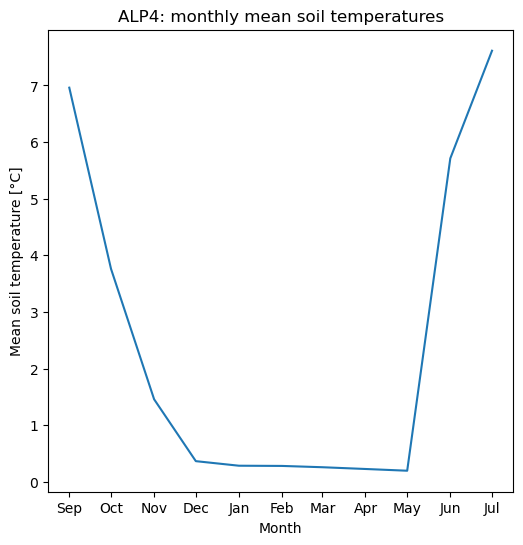

In [84]:
# Plot for quick visualization
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(monthly_mean_df['date_dt'],
        monthly_mean_df['soiltemperature']
       )
ax.set_title(f"{site_code}: monthly mean soil temperatures")
ax.set_xlabel("Month")
ax.set_ylabel("Mean soil temperature [°C]")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

## Modelled and observed in one plot
The observation plot above shows averages from multiple temperature loggers buried at approximately 5 cm depth. We thus calculate the arithmetic mean of the 2nd and 3rd CLM default ground layers (node depths: 4cm and 9cm, respectively) for comparison. We use the range of temperatures for the last 3 simulation years. For interpretation, keep in mind that this exercise makes most sense when the simulation has been properly spun up and the climate forcings within and before that period are comparable to the measurements' observation dates.

### Example plot for one simulation, DB

In [98]:
# Copy the original data
copy = soil_temp_data['DB'].copy()

# Convert the array of month integers to date strings in 'YYYY-MM' format
start_year = 1  # Starting year
end_year = 3  # Ending year
months = np.arange(1, 13)  # Assuming the array contains values for all 12 months
time = [f"{year:02d}-{month:02d}" for year in range(start_year, end_year + 1) for month in months]

# Create a new DataArray with the desired time values
time_coord = xr.DataArray(pd.to_datetime(time, format='%y-%m'), dims='time')
copy = copy.assign_coords(time=time_coord)

# Extract top soil layers (around 10cm), subset last n simulation years defined above, calculate monthly averages (from default 3h model timesteps)
top_2_layer_soil_temp = copy.isel(
    levgrnd=slice(1, 3)
).mean(
    dim="levgrnd"
).resample(time='1M').mean()


In [99]:
# Determine maximum and minimum temperatures over given period
monthly_modelled_max_soil_temp_df = \
top_2_layer_soil_temp.groupby("time.month").max().to_dataframe().reset_index(level=['month', 'lndgrid'])

monthly_modelled_min_soil_temp_df = \
top_2_layer_soil_temp.groupby("time.month").min().to_dataframe().reset_index(level=['month', 'lndgrid'])

In [100]:
# Map modelled monthly values to observed monthly values
monthly_mean_df['model_max_of_mean_monthly_soil_temp'] = None
monthly_mean_df['model_min_of_mean_monthly_soil_temp'] = None

for cur_month in monthly_mean_df['month_int']:
    
    # Max temperatures
    monthly_mean_df.loc[(monthly_mean_df['month_int'] == cur_month),
                        'model_max_of_mean_monthly_soil_temp'] = \
    monthly_modelled_max_soil_temp_df.loc[(monthly_modelled_max_soil_temp_df['month'] == cur_month), 'TSOI'].values
    
    # Min temperatures
    monthly_mean_df.loc[(monthly_mean_df['month_int'] == cur_month),
                        'model_min_of_mean_monthly_soil_temp'] = \
    monthly_modelled_min_soil_temp_df.loc[(monthly_modelled_min_soil_temp_df['month'] == cur_month), 'TSOI'].values

# Convert datatype from object to float (prevents bug in plotting)
monthly_mean_df['model_max_of_mean_monthly_soil_temp'] = monthly_mean_df['model_max_of_mean_monthly_soil_temp'].astype(float)
monthly_mean_df['model_min_of_mean_monthly_soil_temp'] = monthly_mean_df['model_min_of_mean_monthly_soil_temp'].astype(float)
monthly_mean_df

,date_time,soiltemperature,date_dt,month_int,model_max_of_mean_monthly_soil_temp,model_min_of_mean_monthly_soil_temp
0,2015-09,6.961438,2015-09-01,9,10.175919,8.372818
1,2015-10,3.761712,2015-10-01,10,4.639374,3.783936
2,2015-11,1.457354,2015-11-01,11,2.117432,1.172882
3,2015-12,0.364459,2015-12-01,12,0.345764,-0.603424
4,2016-01,0.283917,2016-01-01,1,1.057404,-2.011078
5,2016-02,0.280174,2016-02-01,2,0.229950,-1.002106
6,2016-03,0.257236,2016-03-01,3,0.776138,-2.219528
7,2016-04,0.226174,2016-04-01,4,4.124069,-0.017593
8,2016-05,0.195519,2016-05-01,5,7.833878,2.907761
9,2016-06,5.712489,2016-06-01,6,12.298676,10.915482


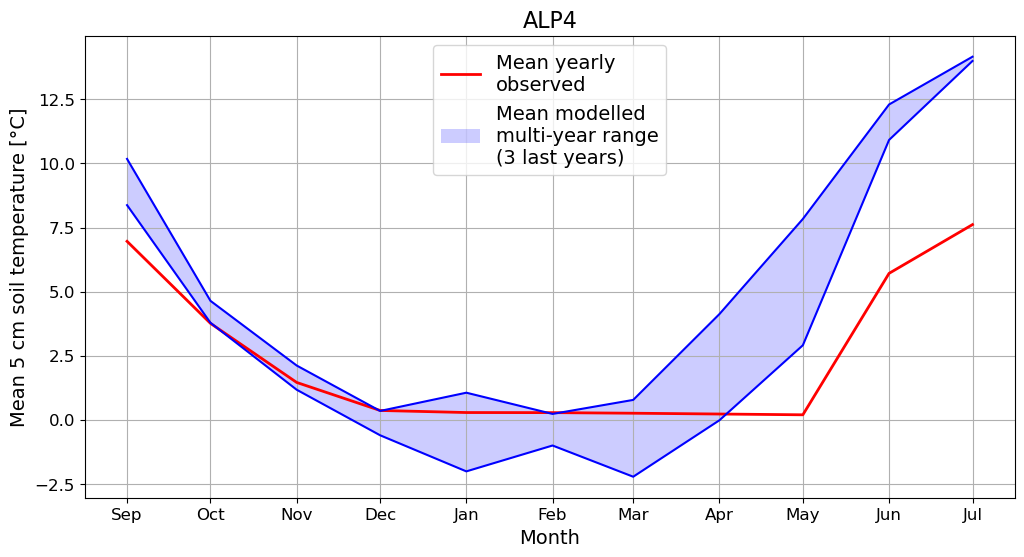

In [102]:
# Create plot
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(monthly_mean_df['date_dt'],
        monthly_mean_df['soiltemperature'],
        color="red",
        linewidth=2,
        label="Mean yearly\nobserved"
       )

ax.plot(monthly_mean_df['date_dt'],
        monthly_mean_df['model_max_of_mean_monthly_soil_temp'],
        color="blue"
       )
ax.plot(monthly_mean_df['date_dt'],
        monthly_mean_df['model_min_of_mean_monthly_soil_temp'],
        color="blue"
       )


ax.fill_between(monthly_mean_df['date_dt'], 
                monthly_mean_df['model_min_of_mean_monthly_soil_temp'],
                monthly_mean_df['model_max_of_mean_monthly_soil_temp'],
                alpha=0.2,
                facecolor="blue",
                label=f"Mean modelled\nmulti-year range\n(3 last years)"
               )

# Plot layout
ax.set_title(f"{site_code}", fontsize=16)
ax.set_ylabel("Mean 5 cm soil temperature [°C]", fontsize=14)
ax.set_xlabel("Month", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.legend(fontsize=14)
ax.grid()

### The same plot for all simulations

In a loop, repeat the same process to make plots for each simulation.

In [115]:
import matplotlib.dates as mdates

simulations = ['DA', 
               'DB', 
               'IA', 
               'IB', 
               'IBSP',
               'IW', 
               'IWSP'
               ]

# Loop over simulations
for sim in simulations:

    print(sim)

    # Extract data and find monthly average
    # ----------------------------------------------------------------------------------------------
    # Copy the original data
    copy = soil_temp_data[sim].copy()

    # Convert the array of month integers to date strings in 'YYYY-MM' format
    start_year = 1  # Starting year
    end_year = 3  # Ending year
    months = np.arange(1, 13)  # Assuming the array contains values for all 12 months
    time = [f"{year:02d}-{month:02d}" for year in range(start_year, end_year + 1) for month in months]

    # Create a new DataArray with the desired time values
    time_coord = xr.DataArray(pd.to_datetime(time, format='%y-%m'), dims='time')
    copy = copy.assign_coords(time=time_coord)

    # Extract top soil layers (around 10cm), subset last n simulation years defined above, calculate monthly averages (from default 3h model timesteps)
    top_2_layer_soil_temp = copy.isel(
        levgrnd=slice(1, 3)
    ).mean(
        dim="levgrnd"
    ).resample(time='1M').mean()


    # Determine maximum and minimum temperatures over given period
    # ----------------------------------------------------------------------------------------------
    monthly_modelled_max_soil_temp_df = \
    top_2_layer_soil_temp.groupby("time.month").max().to_dataframe().reset_index(level=['month', 'lndgrid'])

    monthly_modelled_min_soil_temp_df = \
    top_2_layer_soil_temp.groupby("time.month").min().to_dataframe().reset_index(level=['month', 'lndgrid'])

    # Map modelled monthly values to observed monthly values
    # ----------------------------------------------------------------------------------------------
    monthly_mean_df['model_max_of_mean_monthly_soil_temp'] = None
    monthly_mean_df['model_min_of_mean_monthly_soil_temp'] = None

    for cur_month in monthly_mean_df['month_int']:

        # Max temperatures
        monthly_mean_df.loc[(monthly_mean_df['month_int'] == cur_month),
                            'model_max_of_mean_monthly_soil_temp'] = \
        monthly_modelled_max_soil_temp_df.loc[(monthly_modelled_max_soil_temp_df['month'] == cur_month), 'TSOI'].values

        # Min temperatures
        monthly_mean_df.loc[(monthly_mean_df['month_int'] == cur_month),
                            'model_min_of_mean_monthly_soil_temp'] = \
        monthly_modelled_min_soil_temp_df.loc[(monthly_modelled_min_soil_temp_df['month'] == cur_month), 'TSOI'].values

    # Convert datatype from object to float (prevents bug in plotting)
    monthly_mean_df['model_max_of_mean_monthly_soil_temp'] = monthly_mean_df['model_max_of_mean_monthly_soil_temp'].astype(float)
    monthly_mean_df['model_min_of_mean_monthly_soil_temp'] = monthly_mean_df['model_min_of_mean_monthly_soil_temp'].astype(float)

    # Create plot
    # -------------------------------------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(monthly_mean_df['date_dt'],
            monthly_mean_df['soiltemperature'],
            color="red",
            linewidth=2,
            label="Mean yearly\nobserved"
           )

    ax.plot(monthly_mean_df['date_dt'],
            monthly_mean_df['model_max_of_mean_monthly_soil_temp'],
            color="blue"
           )
    ax.plot(monthly_mean_df['date_dt'],
            monthly_mean_df['model_min_of_mean_monthly_soil_temp'],
            color="blue"
           )


    ax.fill_between(monthly_mean_df['date_dt'], 
                    monthly_mean_df['model_min_of_mean_monthly_soil_temp'],
                    monthly_mean_df['model_max_of_mean_monthly_soil_temp'],
                    alpha=0.2,
                    facecolor="blue",
                    label=f"Mean modelled\nmulti-year range\n(3 last years)"
                   )

    # Plot layout
    ax.set_title(f"{sim}", fontsize=16)
    ax.set_ylabel("Mean 5 cm soil temperature [°C]", fontsize=14)
    ax.set_xlabel("Month", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    ax.legend(fontsize=14)
    ax.grid()

    # Save figure
    fig.tight_layout()
    fig.savefig(fname=f"../../results/figures/soil_temp_vs_obs_{sim}.png", format='png')
    plt.close(fig)

DA
DB
IA
IB
IBSP
IW
IWSP
